In [1]:
# # convert csv to pickle to avoid corruption of data due to csv formatting
import pandas as pd

df = pd.read_csv('listings.csv', low_memory=False)
df.to_pickle('listings.pkl')

In [2]:
# Import modules for feature engineering and modelling
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, OrdinalEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, SGDRegressor, Lasso
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
import warnings
warnings.filterwarnings("ignore")

### I. Importing and Filtering Data

In [3]:
df = pd.read_pickle('listings.pkl')

In [4]:
# remove dollar sign and commas from price
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['description'] = df['description'].astype(str)
df.amenities = df.amenities.apply(literal_eval)

#### 1. Measurement of Well-priced Listings

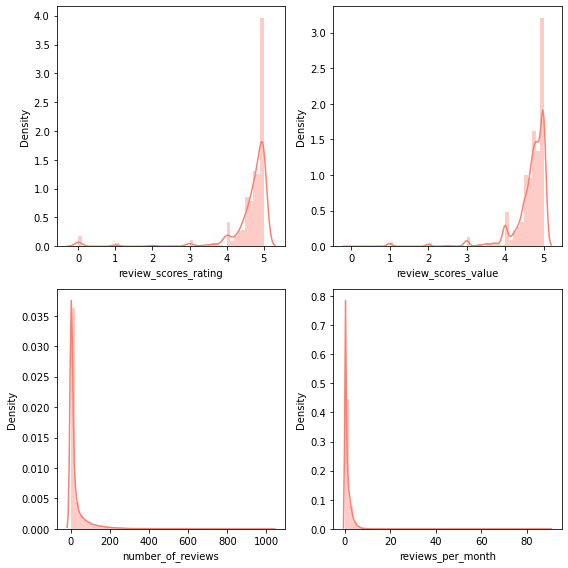

In [5]:
sns.set_palette("muted")

f, ax = plt.subplots(figsize=(8, 8))

subplot(2,2,1)
sns.distplot(df['review_scores_rating'], color = 'salmon')

subplot(2,2,2)
sns.distplot(df['review_scores_value'], color = 'salmon')

subplot(2,2,3)
sns.distplot(df['number_of_reviews'], color = 'salmon')

subplot(2,2,4)
sns.distplot(df['reviews_per_month'], color = 'salmon')

plt.tight_layout() # avoid overlap of plotsplt.draw()

In [6]:
print(df['review_scores_rating'].describe())
print()
print(df['review_scores_value'].describe())
print()
print(df['number_of_reviews'].describe())
print()
print(df['reviews_per_month'].describe())

count    28657.000000
mean         4.605667
std          0.786142
min          0.000000
25%          4.580000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

count    28139.000000
mean         4.648054
std          0.511655
min          0.000000
25%          4.560000
50%          4.780000
75%          5.000000
max          5.000000
Name: review_scores_value, dtype: float64

count    37631.000000
mean        24.663044
std         52.871878
min          0.000000
25%          1.000000
50%          4.000000
75%         22.000000
max       1024.000000
Name: number_of_reviews, dtype: float64

count    28657.000000
mean         1.049115
std          1.795620
min          0.010000
25%          0.120000
50%          0.440000
75%          1.430000
max         90.000000
Name: reviews_per_month, dtype: float64


- Ideally, the column 'review_scores_rating' and 'review_scores_value' should give a direct indication of whether the listing is considered good overall, and of good value for money. From there the deduction that the listing is well-priced can be made.<br>
However, with the distribution of the scores, where even at 25th percentile, these two scores are relatively high at ~4.6/5.0. Thus, there can be two reasons (i) these scores are accurate and reflect the underlying nature of these listings being well priced or (ii) these scores are only reflecting a small minority of guests who truly had this judgement, while the others who did not give any reviews are not well represented.<br>
As the number of reviews is very small to the potential number of guests, we side with the later hypothesis and will adopt additional filters to ensure a higher chance of the selected listings being truly well priced.

- In order to gauge our judgement on which listings are considered well priced, we use the following 2 attributes:<br>
1. `number_of_reviews`: this threshold is chosen to be at least 50 in order to better represent popular opinion over a decent period of time, by common statistical good practice (add-quote). This number is also close to the 85th percentile. As a result, top listings which have been operating for a stable period and collected a reasonable number of guests and reviews should be represented.
2. `reviews_per_month`: we chose this threshold to be at least 1 (average of all listings), in order to be a proxy of how frequently the listings are reviewed, hence the overall rating can be more trustable.

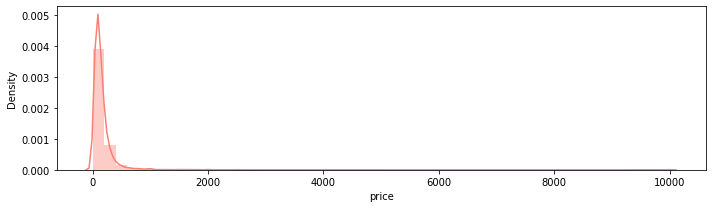

In [7]:
f, ax = plt.subplots(figsize=(10, 3))
sns.distplot(df['price'], color = 'salmon')
plt.tight_layout() 

In [8]:
df['price'].quantile(0.9)

298.0

There are quite a number of outliers with unknown reasons from our perspective. 90% of all listings have prices below USD300 (per day). Hence, in order to model the normal listings, we chose to only focus on listings with price <= USD300

**2.Extracting the well priced listings from EDA exercise**

In Summary, the following conditions are applied:

In [9]:
df_main = df[(df['price']<=300)&\
   (df['number_of_reviews']>=50)&\
   (df['reviews_per_month']>=1)&\
   (df['review_scores_rating']>=4.5)&\
   (df['review_scores_value']>=4.5)
  ]

As seen below, these filtered number of listings displayed a more natural looking distribution of price and ratings. We will treat these listings as being reasonably well-priced and develop a pricing model based on these samples.

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'review_scores_rating'}>],
       [<AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:>]], dtype=object)

<Figure size 432x288 with 0 Axes>

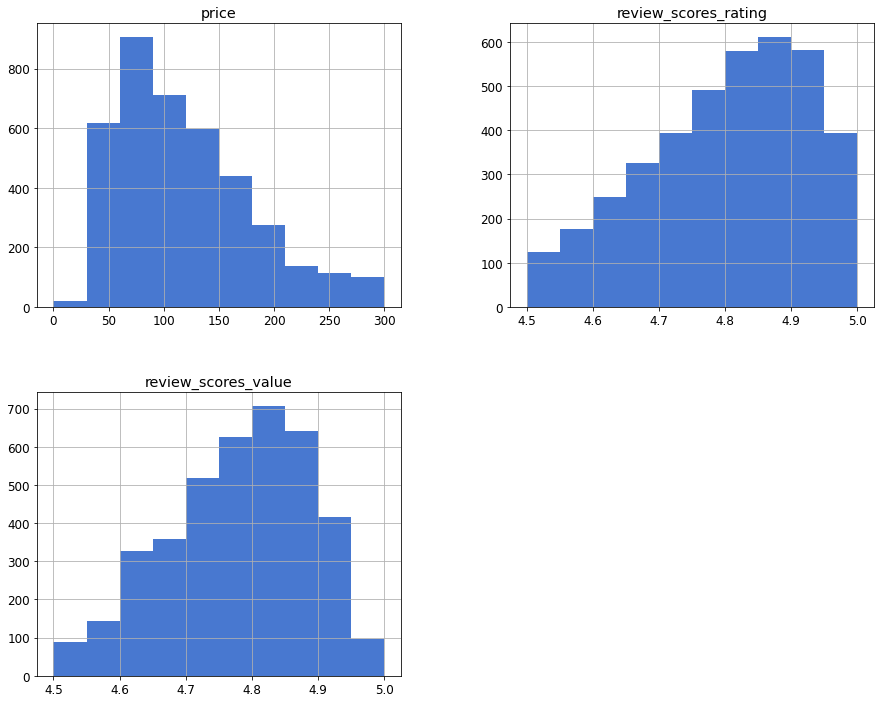

In [10]:
plt.figure()
plt.rcParams.update({'font.size': 12})
df_main.hist(column=['price','review_scores_rating','review_scores_value'], figsize=(15,12))

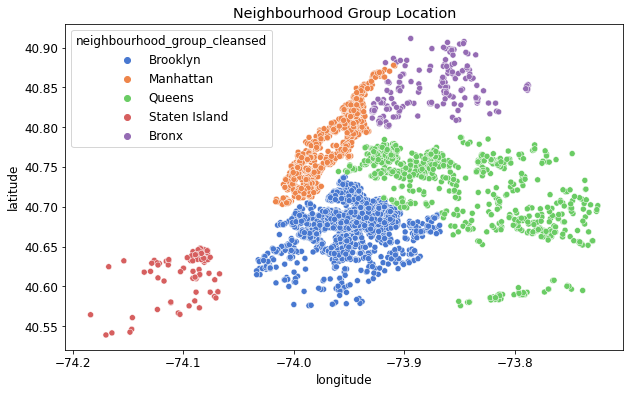

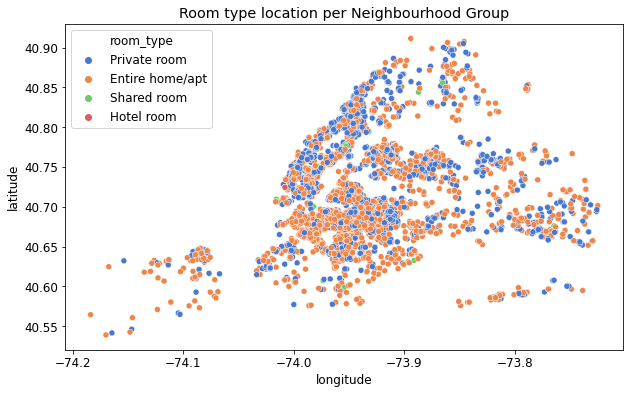

In [11]:
# plot the map
title = 'Neighbourhood Group Location'
plt.figure(figsize=(10,6))
sns.scatterplot(df_main.longitude,df_main.latitude,hue=df_main.neighbourhood_group_cleansed).set_title(title)
plt.ioff()

title = 'Room type location per Neighbourhood Group'
plt.figure(figsize=(10,6))
sns.scatterplot(df_main.longitude,df_main.latitude,hue=df_main.room_type).set_title(title)
plt.ioff()

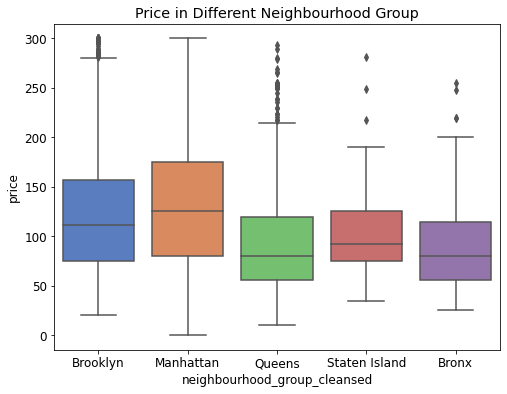

In [12]:
# Price in Different Neighbourhood Group
x= 'neighbourhood_group_cleansed'
y= 'price'
title = 'Price in Different Neighbourhood Group'

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=df_main)
plt.title(title)
plt.ioff()

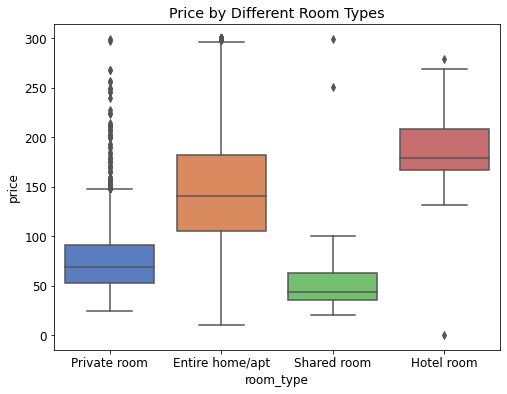

In [13]:
# Price by Different Room Types
x= 'room_type'
y= 'price'
title = 'Price by Different Room Types'

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=df_main)
plt.title(title)
plt.ioff()

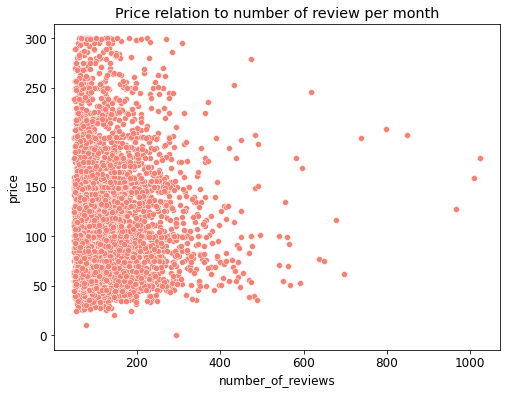

In [88]:
# Price relation to number of review per month
sns.set_palette("muted")
x = 'number_of_reviews'
y = 'price'

title = 'Price relation to number of review per month'

f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df_main, color = 'salmon')
plt.title(title)
plt.ioff()

### II. Feature Engineering - Distance from NYC Anemities:

In [89]:
from sklearn.neighbors import DistanceMetric
import numpy as np

Select necessary columns for faster computation. Converting coordinates to radians for distance calculation

In [90]:
df_coord = df[['id','latitude','longitude','neighbourhood_cleansed','neighbourhood_group_cleansed']].copy()
df_coord[['latitude_rad_listing','longitude_rad_listing']] = (np.radians(df_coord.loc[:,['latitude','longitude'
                                                                                        ]]))

#### 1. Nearest Subway Stations

In [91]:
df_subway = pd.read_csv('nyc_subway_stations.csv')
df_subway = df_subway[['Station Name', 'Station Latitude','Station Longitude']]
df_subway.drop_duplicates(subset=['Station Name'], inplace = True)
df_subway[['latitude_rad_station','long_radians_station']] = (np.radians(df_subway.loc[:,['Station Latitude','Station Longitude']])) #convert to radians
dist = DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise(df_coord[['latitude_rad_listing','longitude_rad_listing']],
     df_subway[['latitude_rad_station','long_radians_station']])*6371)
# Note that 6371 is the earth radius in Km
df_dist = pd.DataFrame(dist_matrix,index=df_coord['id'], 
                 columns=df_subway['Station Name'])
# unpivot from fat to long form
df_dist_long = (pd.melt(df_dist.reset_index(),id_vars='id'))
df_dist_long = df_dist_long.rename(columns={'value':'km'})
df_listing_to_subway = df_dist_long.sort_values(by=['id','km'], ascending = [True, True]).drop_duplicates(subset='id', keep='first')
df_listing_to_subway.rename(columns={'Station Name':'Nearest Station', 'km':'Distance to Nearest Subway Station (km)'}, inplace=True)

#### 2. Nearest Shopping Centers and City Plazas

In [92]:
df_shopping = pd.read_csv('nyc_shopping.csv')
df_shopping[['latitude_rad_shopping','long_radians_shopping']] = (np.radians(df_shopping.loc[:,['latitude','longitude']]))
dist = DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise(df_coord[['latitude_rad_listing','longitude_rad_listing']],
     df_shopping[['latitude_rad_shopping','long_radians_shopping']])*6371)
# Note that 6371 is the earth radius in Km
df_dist = pd.DataFrame(dist_matrix,index=df_coord['id'], columns=df_shopping['facname'])
# unpivot from fat to long form
df_dist_long = (pd.melt(df_dist.reset_index(),id_vars='id'))
df_dist_long = df_dist_long.rename(columns={'value':'km'})
df_listing_to_shopping = df_dist_long.sort_values(by=['id','km'], ascending = [True, True]).drop_duplicates(subset='id', keep='first')
df_listing_to_shopping.rename(columns={'facname':'Nearest Shopping Mall', 'km':'Distance to Nearest Shopping Mall (km)'}, inplace=True)

#### 3. Nearest Top 10 Tourist Attractions

In [93]:
df_top10 = pd.read_csv('nyc_top10attractions.csv')
df_top10[['latitude_rad_top10','long_radians_top10']] = (np.radians(df_top10.loc[:,['latitude','longitude']]))
dist = DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise(df_coord[['latitude_rad_listing','longitude_rad_listing']],
     df_top10[['latitude_rad_top10','long_radians_top10']])*6371)
# Note that 6371 is the earth radius in Km
df_dist = pd.DataFrame(dist_matrix,index=df_coord['id'], columns=df_top10['attraction'])
# unpivot from fat to long form
df_dist_long = (pd.melt(df_dist.reset_index(),id_vars='id'))
df_dist_long = df_dist_long.rename(columns={'value':'km'})
df_listing_to_top10 = df_dist_long.sort_values(by=['id','km'], ascending = [True, True]).drop_duplicates(subset='id', keep='first')
df_listing_to_top10.rename(columns={'attraction':'Nearest Top 10 Attraction', 'km':'Distance to Nearest Top 10 Attraction (km)'}, inplace = True)

#### 4. Merging to the main df

In [94]:
df = pd.merge(left=df, right=df_listing_to_subway,how='inner', on='id')
df = pd.merge(left=df, right=df_listing_to_shopping,how='inner', on='id')
df = pd.merge(left=df, right=df_listing_to_top10,how='inner', on='id')

#### 5. Derive a new attribute from 'anemities' column

In [35]:
df['num_amenities'] = df['amenities'].apply(lambda x: len(x))

#### 6. Derive new attributes from 'Description' column

In [36]:
# Preprocessing Description columns
df['description'] = [re.sub('</?([a-z]+)>', ' ', x) for x in df['description']]
df['description'] = [re.sub('<[^>]*>', '', x) for x in df['description']]
df['description'] = [re.sub('\s+', ' ', x) for x in df['description']]
df['description'] = [x.lower() for x in df['description']]

#number of unique words in description
df['num_desc'] = df['description'].apply(lambda x: len(x.split()))

#number of sentences in description
df['num_sent'] = df['description'].apply(lambda x: len(x.split('.')))

#average word length
df['avg_word_len'] = df['description'].apply(lambda x: sum([len(word) for word in x.split()])/len(x.split()))

#### 7. Dropping Redundant columns (e.g., URL, empty, repeated info)

In [37]:
print("Number of current columns:", len(df.columns))

Number of current columns: 84


After the 1st-round of data field examination, we decided to drop the following columns since they are not necessary.
For example, we dropped the nearest station/shopping mall/top10 columns so that the distance columns become clearer attibutors. We also dropped neighborhood column instead of neighborhood groups for broader geographical boundaries.

In [15]:
# Names of columns to drop
drop = ['listing_url', 'scrape_id', 'last_scraped', 'name',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood',
       'neighbourhood_cleansed', 'bathrooms', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'Nearest Station', 'Nearest Shopping Mall',
       'Nearest Top 10 Attraction','longitude','latitude']
len(drop)

39

In [16]:
# Create a new data frame after dropping redundant columns
df_main = df.drop(drop, axis=1)

In [17]:
print("Number of remaining columns:", len(df_main.columns))

Number of remaining columns: 45


#### 8. Converting a few columns to numerical values

In [18]:
display(df_main[['bathrooms_text']].head(2))
print('convert to')
df_main['bathrooms']=df_main['bathrooms_text'].str.extract(r'(\d+\.?\d*)')
display(df_main[['bathrooms']].head(2))

,bathrooms_text
0,1.5 baths
1,1 bath


convert to


,bathrooms
0,1.5
1,1


In [19]:
display(df_main[['host_response_rate']].head(2))
print('convert to')
df_main['host_response_rate']=df_main['host_response_rate'].str.extract(r'(\d+\.?\d*)')
display(df_main[['host_response_rate']].head(2))

,host_response_rate
0,100%
1,100%


convert to


,host_response_rate
0,100
1,100


In [20]:
display(df_main[['host_acceptance_rate']].head(2))
print('convert to')
df_main['host_acceptance_rate']=df_main['host_acceptance_rate'].str.extract(r'(\d+\.?\d*)')
display(df_main[['host_acceptance_rate']].head(2))

,host_acceptance_rate
0,100%
1,100%


convert to


,host_acceptance_rate
0,100
1,100


In [21]:
df_main = df_main.astype({'bathrooms': 'float64','host_response_rate': 'float64','host_acceptance_rate': 'float64'})

### III. DATA TRANSFORMATION

Before feeding our training data into a pipeline for further transformation, we divide current features into subset of features, to which we will apply different transformation methods.

In [22]:
########## Groups of columns for ColumnTransformer: #############

# Numerical columns
num_cols = list(df_main.select_dtypes(include=['float64','int64']).columns)
num_cols.remove('price')
num_cols.remove('id')
print("Number of numerical attributes:", len(num_cols))
# categorical column
cat_cols = list(df_main.select_dtypes(include=['object']).columns)
cat_cols.remove('description')
cat_cols.remove('bathrooms_text')
cat_cols.remove('amenities')
print("Number of categorical attributes:", len(cat_cols))

# List-type column
list_col = 'amenities'
print("Number of list attributes:", len(list_col))
# Others
other_col = ['id','price']
print("Number of other attributes:", len(other_col))

Number of numerical attributes: 34
Number of categorical attributes: 7
Number of list attributes: 9
Number of other attributes: 2


In [23]:
# Preparing final training data
df_train = df_main[other_col+ cat_cols + [list_col]+num_cols].copy()
# set index to id
df_train.set_index('id', inplace=True)

#### Drop NA (bedrooms, 361 rows)

In [24]:
print("Size Before:", len(df_train))
df_train.dropna(inplace=True)
print("Size After:", len(df_train))

Size Before: 3924
Size After: 2985


#### Define X and y

In the modelling section, we will explore linear regression model for price pridiction. 
Since the linear regression model is subject to multicorrelation issue, we examine the issue of multicorrelation for our current numerical attributes.

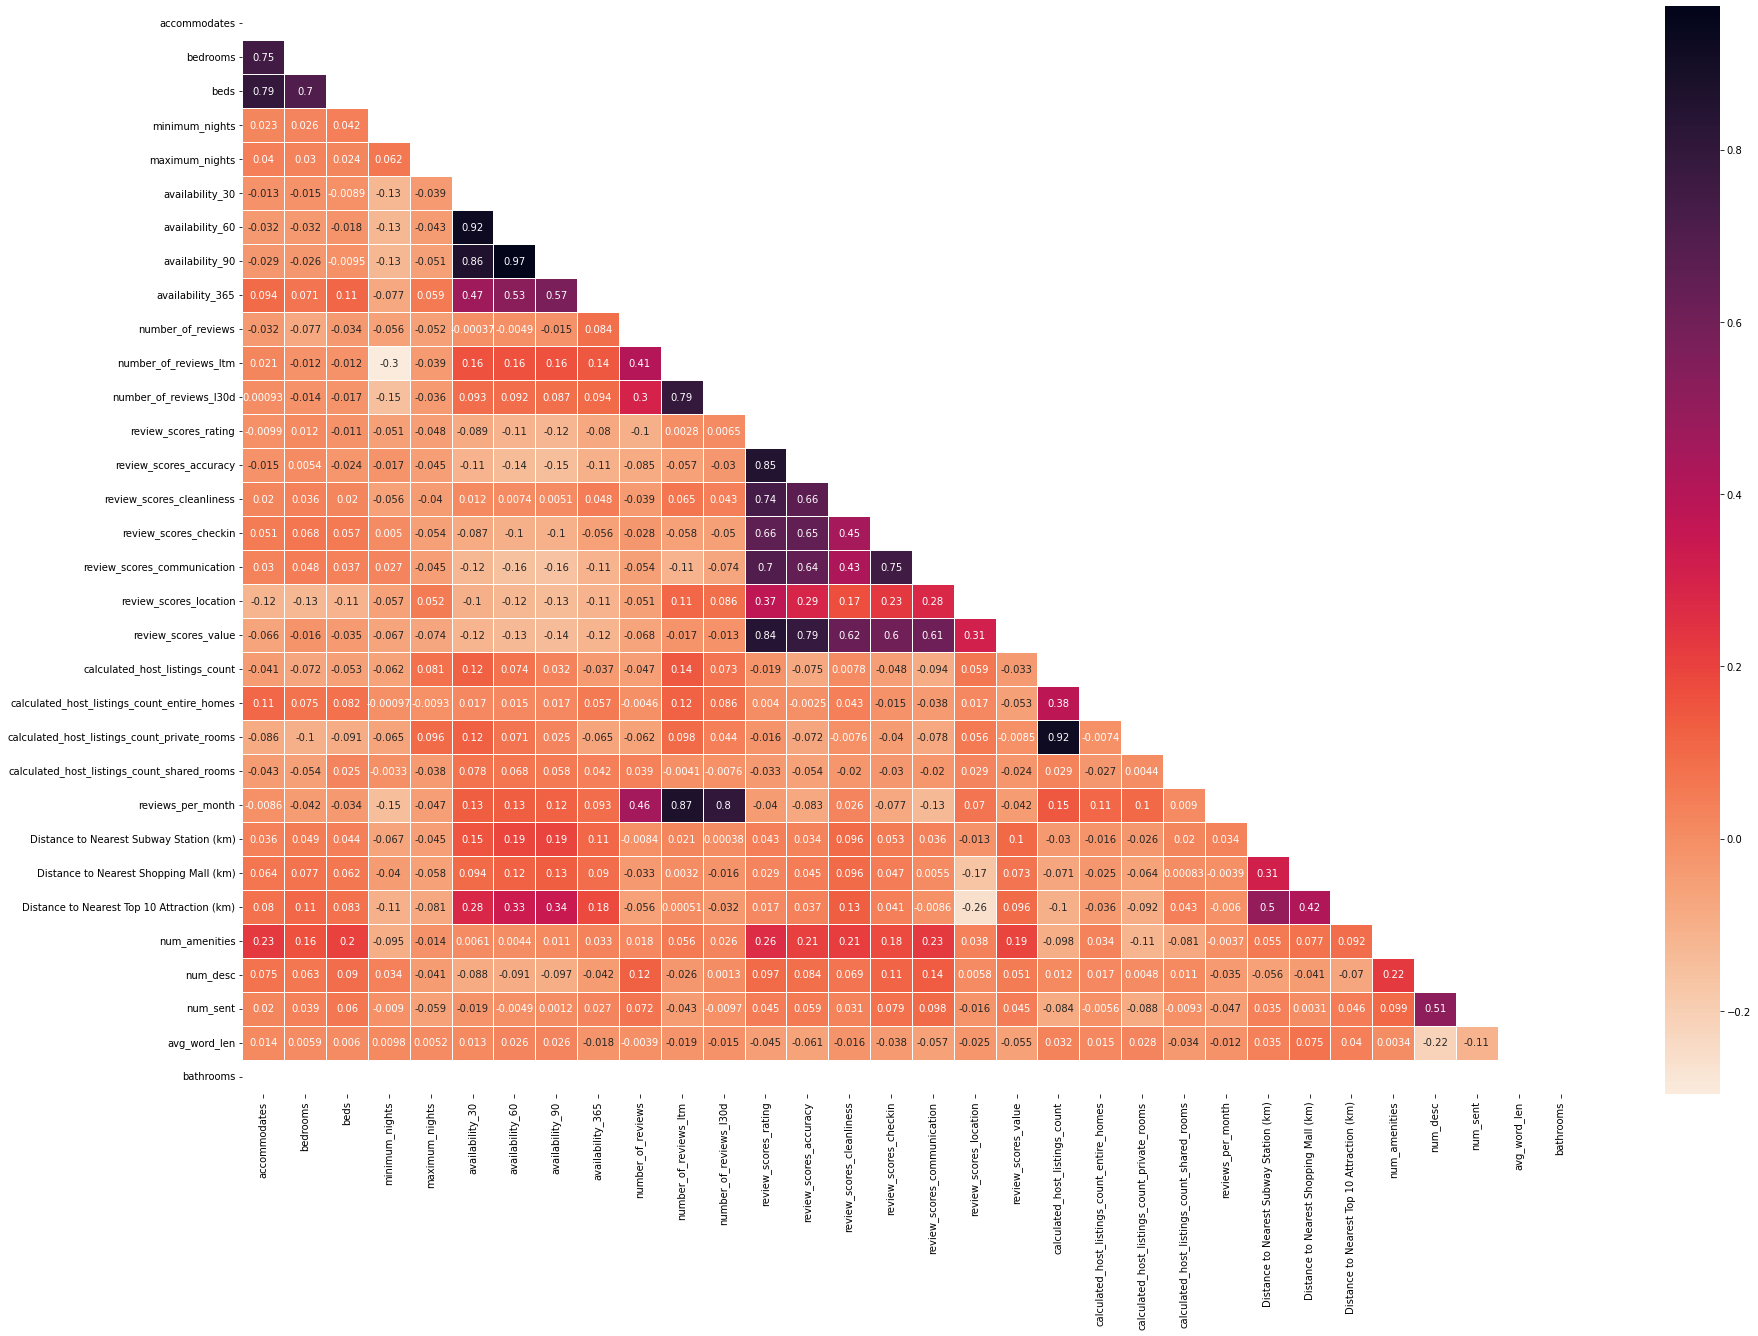

In [25]:
# Examine correlations amongst numerical attributes
corrMatrix = df[num_cols].corr()
matrix = np.triu(corrMatrix)
fig, ax = plt.subplots(figsize=(30,20))
ax = sns.heatmap(corrMatrix, annot = True, mask = matrix, linewidths=.5, cmap = "rocket_r", fmt='.2g')
plt.show()

We decided to drop the following numerical attributes to avoid Multicollinearity

In [26]:
num_cols_to_drop = ['beds','accommodates', 'availability_60','availability_90', 'number_of_reviews_ltm','review_scores_accuracy'
                   ,'review_scores_cleanliness','review_scores_communication','review_scores_value'
                    ,'calculated_host_listings_count','reviews_per_month']

In [27]:
num_cols = [col for col in num_cols if col not in num_cols_to_drop]

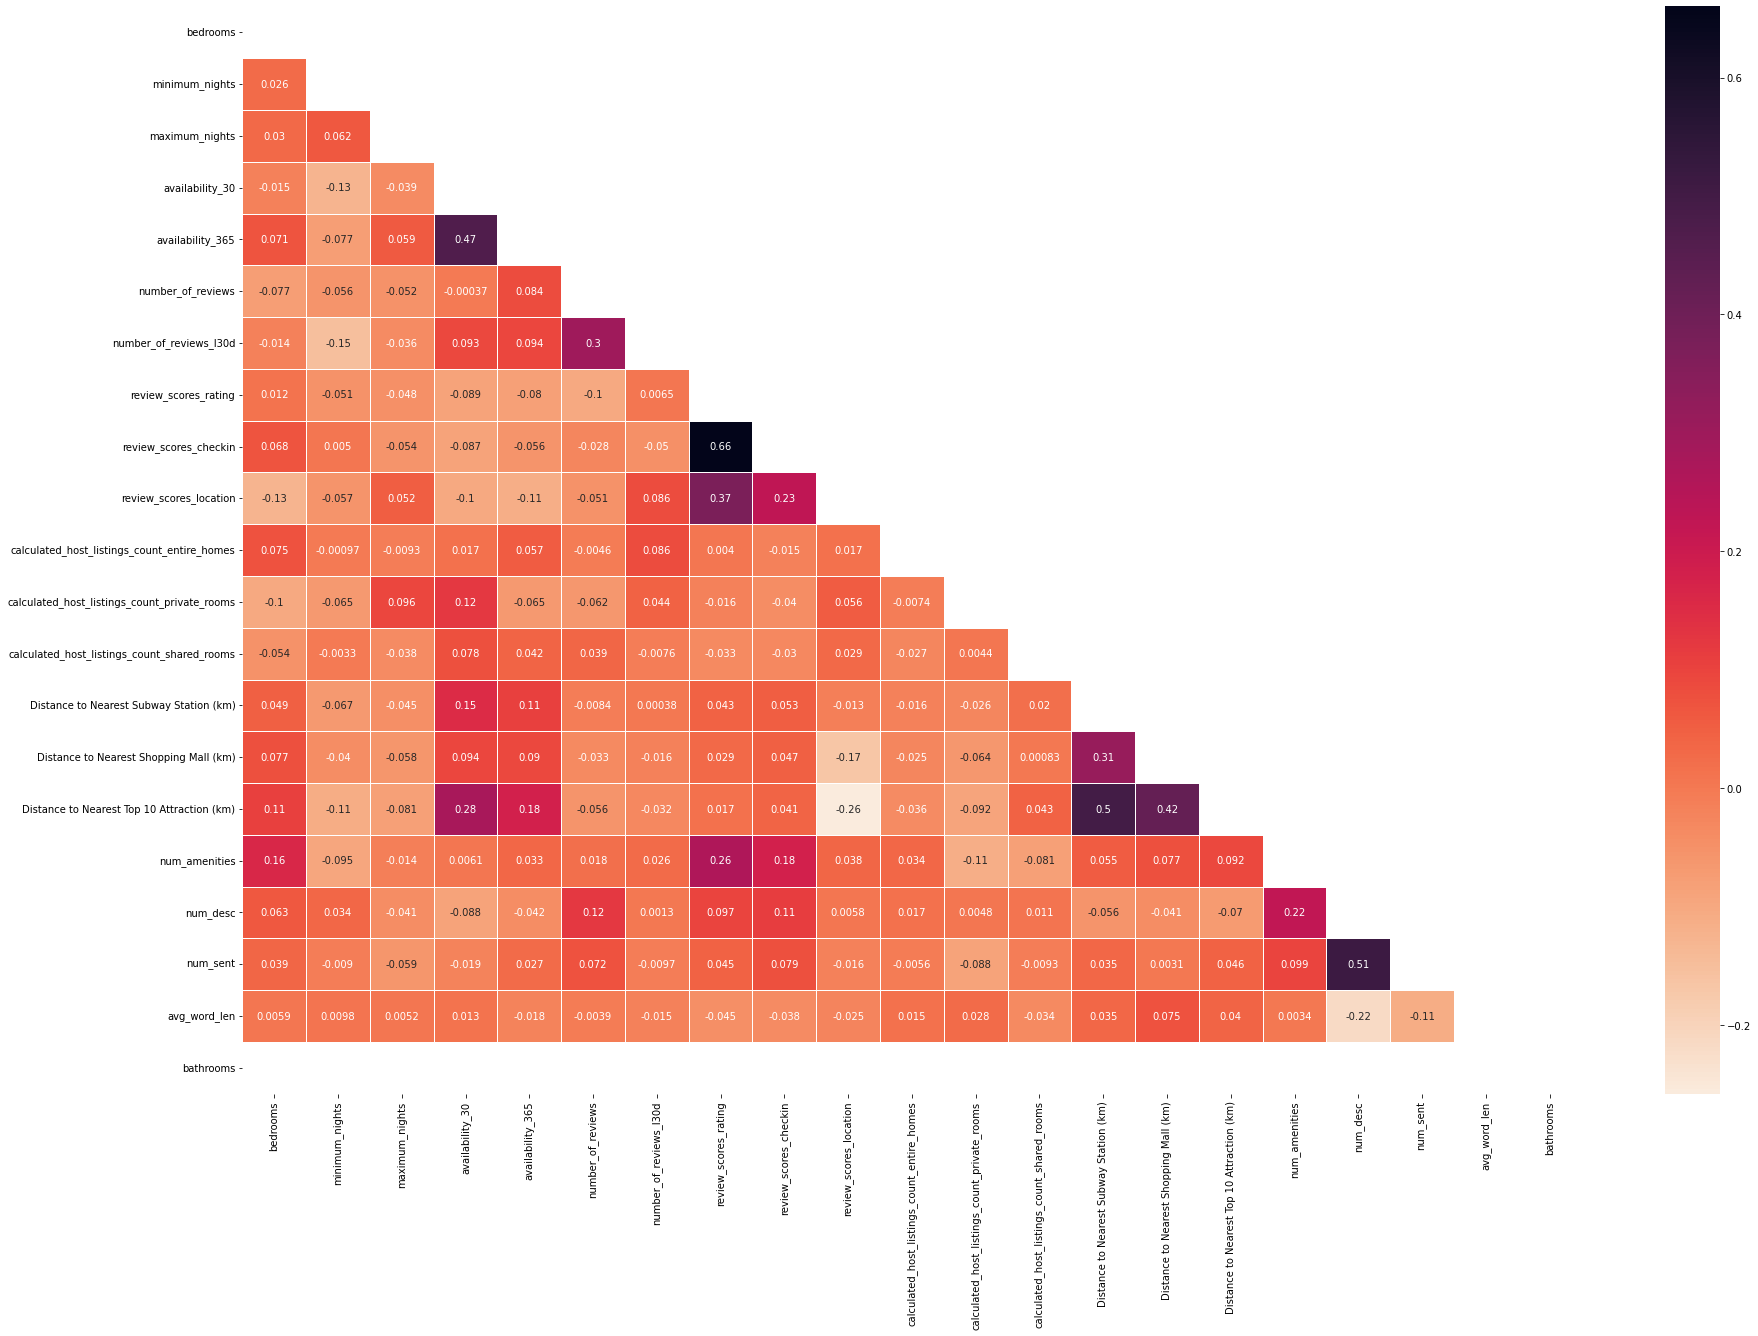

In [28]:
# Examine correlations amongst numerical attributes again
corrMatrix = df[num_cols].corr()
matrix = np.triu(corrMatrix)
fig, ax = plt.subplots(figsize=(30,20))
ax = sns.heatmap(corrMatrix, annot = True, mask = matrix, linewidths=.5, cmap = "rocket_r", fmt='.2g')
plt.show()

We can see that there is no strong correlation amongst the above attributes. They will be used in linear regression model as well as other linear models 

Finally, the following attributes will be used in our models:

In [29]:
pd.DataFrame(data=df_train[[list_col]+num_cols+cat_cols].columns, columns = ['column_name'])

,column_name
0,amenities
1,host_response_rate
2,host_acceptance_rate
3,bedrooms
4,minimum_nights
5,maximum_nights
6,availability_30
7,availability_365
8,number_of_reviews
9,number_of_reviews_l30d


In [30]:
# initial X and y set for listings
X = df_train[[list_col]+num_cols+cat_cols]
y = df_train['price']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

Apply column transformation:

In [31]:
# Create a custom pass-through function for the aminities, since they are
# already tokenized. We will only use CountVectorizer to split the amenities
# into separate feature columns.
def no_analyzer(doc):
    """Pass-through function to avoid transforming amenities lists, which are 
    already tokenized.
    """
    return doc
########## Pipeline for features #############
cols_trans = ColumnTransformer([
    ('txt_kw', CountVectorizer(analyzer=no_analyzer, max_features=200), list_col),
    ('oe', OneHotEncoder(handle_unknown = 'ignore'), cat_cols), #IMPT: NEED TO SET handle_unknown = 'ignore'
    ('number', StandardScaler(), num_cols)], remainder='drop')

In [32]:
pipe = Pipeline([
    ('trans', cols_trans),
    ('model', LinearRegression())
])

In [33]:
cols_trans

ColumnTransformer(transformers=[('txt_kw',
                                 CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                 max_features=200),
                                 'amenities'),
                                ('oe', OneHotEncoder(handle_unknown='ignore'),
                                 ['host_is_superhost', 'host_has_profile_pic',
                                  'host_identity_verified',
                                  'neighbourhood_group_cleansed',
                                  'property_type', 'room_type',
                                  'instant_bookable']),
                                ('number', Standa...
                                  'review_scores_checkin',
                                  'review_scores_location',
                                  'calculated_host_listings_count_entire_homes',
                                  'calculated_host_listings_count_private_rooms',

### IV. MODELLING

#### 1. Baseline Linear Regression Model

In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                                  max_features=200),
                                                  'amenities'),
                                                 ('oe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'neighbourhood_group_cleansed',
                                                   'property_type', 'room_type',
                                                   'instant_boo...
                                           

In [35]:
# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
print('R2 score for train: %.2f' % r2_score(y_train, pipe.predict(X_train)))
print('R2 score for test: %.2f' % r2_score(y_test, y_pred))
print('Mean squared error for test: %.2f' % mean_squared_error(y_test, y_pred))


R2 score for train: 0.70
R2 score for test: 0.59
Mean squared error for test: 1725.91


In [36]:

# get important features
txt_kw = list(pipe.steps[0][1].named_transformers_['txt_kw'].get_feature_names_out())
oe = list(pipe.steps[0][1].named_transformers_['oe'].get_feature_names_out())

features = []
features_cat = []
for i in [('Tokenized_amenities', txt_kw), ('Categorical', oe), ('Numeric', num_cols)]:
    features.extend(i[1])
    features_cat.extend([i[0]]*len(i[1]))

importance = pipe.steps[1][1].coef_
importance = pd.DataFrame({'type': features_cat, 'importance': importance}, index=features)
importance.sort_values(by='importance', ascending=False, inplace=True)
importance.head(20)

,type,importance
Bluetooth sound system,Tokenized_amenities,50.878777
property_type_Private room in serviced apartment,Categorical,48.596307
property_type_Shared room in townhouse,Categorical,46.929798
property_type_Tiny house,Categorical,46.220379
Free washer – In building,Tokenized_amenities,40.678612
property_type_Room in hotel,Categorical,39.283351
property_type_Entire cottage,Categorical,37.170236
HDTV,Tokenized_amenities,31.340219
Private hot tub,Tokenized_amenities,30.940669
num_amenities,Numeric,30.535229


#### 2. Other Linear Regression and Tree Models

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
from scipy.stats import uniform, truncnorm, randint
import xgboost as xgb

In [38]:
# Create a RandomizedSearchCV function to find the best parameters/hyperparameters tuning
def RandomizedSearchCV_function(X_train, y_train, regressor, parameters):
    # Create pipeline
    pipe = Pipeline([
    ('trans', cols_trans),
    ('model', regressor)
    ])

    # Create a randomized search cv object
    rnd_search = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='r2', n_jobs=-1, n_iter=20)

    # Fit the model
    rnd_search.fit(X_train, y_train)
    best_model = rnd_search.best_estimator_
    print('Best score for {}: {}'.format(regressor.__class__.__name__, rnd_search.best_score_))
    print('Best parameters: ', rnd_search.best_params_)
    print('='*50)
    return best_model

# Create a custom function to show performance and importance of features
def show_performance(model_name, model, X_test, y_test):
    # Predict on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    print('R2 score for train: %.2f' % r2_score(y_train, model.predict(X_train)))
    print('R2 score for test: %.2f' % r2_score(y_test, y_pred))
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
    
    # Determine indivdiual or stacking regressor and get important features 
    if hasattr(model, 'final_estimator_'):
        importance = model.final_estimator_.coef_
        models = model.named_estimators_
        importance = pd.DataFrame(importance, index=models, columns=['Final Estimator Coefs'])
        importance.sort_values(by='Final Estimator Coefs', ascending=False, inplace=True)
        return importance
    else:
        if hasattr(model.steps[1][1], 'coef_'):
            importance = model.steps[1][1].coef_
        elif hasattr(model.steps[1][1], 'feature_importances_'):
            importance = model.steps[1][1].feature_importances_
        else:
            return print('Model does not have coef_ or feature_importances_ attribute')
        importance = pd.DataFrame({'type': features_cat, 'importance_'+model_name: importance, 'feature': features})
        importance.sort_values(by='importance_'+model_name, ascending=False, inplace=True)
        return importance

In [39]:
# Create the models and append it to regressors
regressors = []
regressors.append(('linear', pipe))
regressors.append(('ridge', RandomizedSearchCV_function(X_train, y_train, Ridge(), {'model__alpha': uniform(0.1,1), 'model__fit_intercept': [True, False], 'model__random_state': [2022]})))
regressors.append(('lasso', RandomizedSearchCV_function(X_train, y_train, Lasso(max_iter=10000), {'model__alpha': uniform(0.1,1), 'model__fit_intercept': [True, False], 'model__random_state': [2022]})))
regressors.append(('sgdr', RandomizedSearchCV_function(X_train, y_train, SGDRegressor(), {'model__alpha': uniform(0.0001,1), 'model__fit_intercept': [True, False], 'model__penalty': ['l1', 'l2'], 'model__random_state': [2022]})))
regressors.append(('dt', RandomizedSearchCV_function(X_train, y_train, DecisionTreeRegressor(), {'model__max_depth': randint(2,20), 'model__min_samples_split': randint(2,20), 'model__min_samples_leaf': randint(1,20), 'model__max_features': [None, 'sqrt', 'log2'], 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'], 'model__random_state': [2022]})))
regressors.append(('rf', RandomizedSearchCV_function(X_train, y_train, RandomForestRegressor(), {'model__criterion': ['squared_error', 'absolute_error'], 'model__max_depth': randint(2,20), 'model__min_samples_split': randint(2,20), 'model__min_samples_leaf': randint(1,20), 'model__max_features': [None, 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('et', RandomizedSearchCV_function(X_train, y_train, ExtraTreesRegressor(), {'model__criterion': ['squared_error', 'absolute_error'], 'model__max_depth': randint(2,20), 'model__min_samples_split': randint(2,20), 'model__min_samples_leaf': randint(1,20), 'model__max_features': [None, 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('ab', RandomizedSearchCV_function(X_train, y_train, AdaBoostRegressor(DecisionTreeRegressor(max_depth=3)), {'model__n_estimators': randint(2,100), 'model__learning_rate': uniform(0.01,1), 'model__random_state': [2022]})))
regressors.append(('gb', RandomizedSearchCV_function(X_train, y_train, GradientBoostingRegressor(), {'model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'model__learning_rate': uniform(0.001,1), 'model__criterion': ['friedman_mse', 'squared_error'], 'model__max_depth': randint(2,20), 'model__min_samples_split': randint(2,20), 'model__min_samples_leaf': randint(1,20), 'model__max_features': ['auto', 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('xgb', RandomizedSearchCV_function(X_train, y_train, xgb.XGBRegressor(), {'model__max_depth': [3, 5, 6, 10, 15, 20],'model__colsample_bytree': np.arange(0.4, 1.0, 0.1),'model__subsample': np.arange(0.5, 1.0, 0.1), 'model__learning_rate': [0.01, 0.1, 0.2, 0.3], 'model__n_estimators': [100, 500, 1000], 'model__random_state': [2022]})))


Best score for Ridge: 0.6137792846698189
Best parameters:  {'model__alpha': 1.0935110630387528, 'model__fit_intercept': False, 'model__random_state': 2022}
Best score for Lasso: 0.6272319962768902
Best parameters:  {'model__alpha': 0.1575944358103725, 'model__fit_intercept': False, 'model__random_state': 2022}
Best score for SGDRegressor: 0.6281070794301092
Best parameters:  {'model__alpha': 0.05381529398501107, 'model__fit_intercept': False, 'model__penalty': 'l1', 'model__random_state': 2022}
Best score for DecisionTreeRegressor: 0.5700952137249937
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 14, 'model__max_features': None, 'model__min_samples_leaf': 19, 'model__min_samples_split': 7, 'model__random_state': 2022}
Best score for RandomForestRegressor: 0.6741684343135708
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 12, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_s

In [40]:
print('Model name:', 'linear')
importance = show_performance(str(regressors[0][0]), regressors[0][1], X_test, y_test)
print('='*50)
for regressor in regressors[1:]:
    print('Model name:', regressor[0])
    importance_sub = show_performance(str(regressor[0]), regressor[1], X_test, y_test)
    print('='*50)
    importance = pd.merge(importance, importance_sub[[c for c in importance_sub.columns if c != 'type']], how='left', on='feature')
importance.set_index(keys='feature', inplace=True)
importance.head(5)

Model name: linear
R2 score for train: 0.70
R2 score for test: 0.59
Mean squared error: 1725.91
Model name: ridge
R2 score for train: 0.69
R2 score for test: 0.62
Mean squared error: 1622.61
Model name: lasso
R2 score for train: 0.66
R2 score for test: 0.63
Mean squared error: 1583.56
Model name: sgdr
R2 score for train: 0.67
R2 score for test: 0.62
Mean squared error: 1608.36
Model name: dt
R2 score for train: 0.73
R2 score for test: 0.60
Mean squared error: 1704.18
Model name: rf
R2 score for train: 0.89
R2 score for test: 0.68
Mean squared error: 1365.36
Model name: et
R2 score for train: 0.95
R2 score for test: 0.65
Mean squared error: 1484.52
Model name: ab
R2 score for train: 0.60
R2 score for test: 0.57
Mean squared error: 1817.98
Model name: gb
R2 score for train: 0.83
R2 score for test: 0.65
Mean squared error: 1483.66
Model name: xgb
R2 score for train: 0.79
R2 score for test: 0.68
Mean squared error: 1337.51


,type,importance_linear,importance_ridge,importance_lasso,importance_sgdr,importance_dt,importance_rf,importance_et,importance_ab,importance_gb,importance_xgb
feature,,,,,,,,,,,
Bluetooth sound system,Tokenized_amenities,50.878777,26.590568,0.0,3.823668,0.0,0.0,0.001922,0.0,0.000000,0.004988
property_type_Private room in serviced apartment,Categorical,48.596307,7.625421,0.0,0.000000,0.0,0.0,0.000618,0.0,0.000000,0.000000
property_type_Shared room in townhouse,Categorical,46.929798,4.249784,0.0,0.000000,0.0,0.0,0.000007,0.0,0.000000,0.000000
property_type_Tiny house,Categorical,46.220379,7.386803,0.0,0.000000,0.0,0.0,0.000076,0.0,0.000000,0.000000
Free washer – In building,Tokenized_amenities,40.678612,10.681282,0.0,0.833187,0.0,0.0,0.000090,0.0,0.000326,0.000000


Scale the data in importance without column type with min-max scaler

In [41]:

importance_scaled = importance.drop(columns=['type'])
importance_scaled = pd.DataFrame(MinMaxScaler().fit_transform(importance_scaled), columns=importance_scaled.columns, index=importance_scaled.index)
importance_scaled['importance_total'] = importance_scaled.sum(axis=1)
importance_scaled.sort_values(by='importance_total', ascending=False, inplace=True)
importance_scaled.head(5)

,importance_linear,importance_ridge,importance_lasso,importance_sgdr,importance_dt,importance_rf,importance_et,importance_ab,importance_gb,importance_xgb,importance_total
feature,,,,,,,,,,,
room_type_Entire home/apt,0.822070,0.993266,0.898491,1.000000,1.000000,1.000000,1.000000,1.000000,0.845331,0.716104,9.275263
bedrooms,0.721085,0.792351,0.420630,0.660722,0.179625,0.182457,0.147681,0.265144,0.728902,0.114299,4.212895
Distance to Nearest Top 10 Attraction (km),0.466207,0.310284,0.024862,0.064769,0.435207,0.452207,0.162476,0.517986,1.000000,0.123458,3.557456
neighbourhood_group_cleansed_Manhattan,0.777871,0.971249,0.528820,0.805526,0.000000,0.001435,0.125043,0.000000,0.100817,0.101653,3.412413
host_has_profile_pic_t,0.660401,0.906038,1.000000,0.694843,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,3.261290


<AxesSubplot:ylabel='feature'>

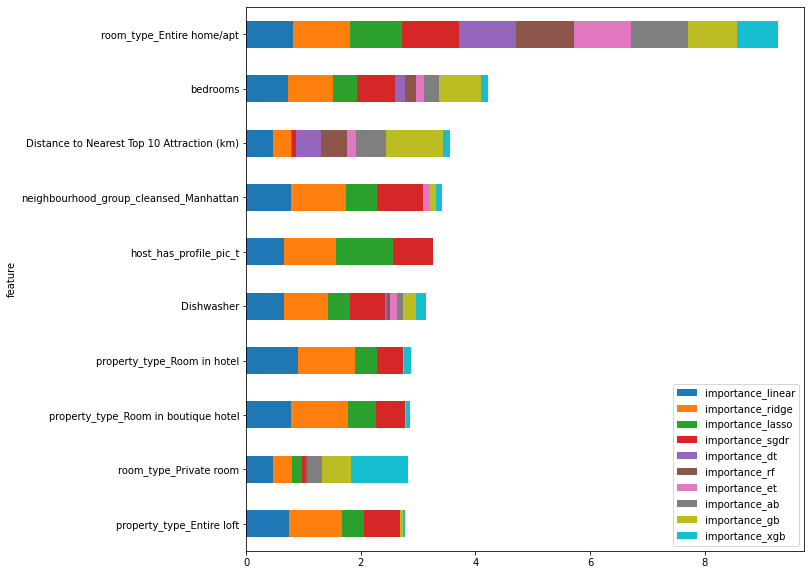

In [42]:
# Plot stacked horizontal bar chart of importance_scaled
importance_plot = importance_scaled[:10].sort_values(by='importance_total', ascending=True)
importance_plot.drop(columns=['importance_total'], inplace=True)
importance_plot.plot.barh(stacked=True, figsize=(10,10))


#### 3. The Stacking Model

In [43]:
from sklearn.ensemble import StackingRegressor

**Build a stacking model by using all models**

In [44]:
# Create a stacking regressor
clf = StackingRegressor(estimators=regressors, n_jobs=-1, passthrough=False)
# Fit the model
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('linear',
                               Pipeline(steps=[('trans',
                                                ColumnTransformer(transformers=[('txt_kw',
                                                                                 CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                                                                 max_features=200),
                                                                                 'amenities'),
                                                                                ('oe',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['host_is_superhost',
                                                                                  'host_has_profile_pic',
                               

In [45]:
# Show performance of the stacking model
stacking_importance = show_performance('Stacking', clf, X_test, y_test)
display(stacking_importance)

R2 score for train: 0.90
R2 score for test: 0.71
Mean squared error: 1249.80


,Final Estimator Coefs
rf,0.446261
xgb,0.384064
sgdr,0.278390
gb,0.228693
et,0.151996
linear,0.034725
ridge,0.033003
dt,0.019023
lasso,-0.249048
ab,-0.311998


Summary of feature important from all models. Feature importance is weighted by the weights of respective models in the stacking model.

In [46]:
# Remove 'importance_' from names of 'importance_scaled's columns. This is for visualization. 
importance_scaled.columns = [c.replace('importance_', '') for c in importance_scaled.columns]
importance_scaled_sub = importance_scaled.drop('total', axis=1)

def multiply_stacking(column):
    multiplier = float(stacking_importance.loc[stacking_importance.index == column.name]['Final Estimator Coefs'])
    return column * multiplier

# Multiply importance_scaled by stacking_importance's Final Estimator Coefs by column
importance_weighted = importance_scaled_sub.apply(multiply_stacking, axis=0)
importance_weighted.head(5)

,linear,ridge,lasso,sgdr,dt,rf,et,ab,gb,xgb
feature,,,,,,,,,,
room_type_Entire home/apt,0.028546,0.032781,-0.223768,0.278390,0.019023,0.446261,0.151996,-0.311998,0.193321,0.275030
bedrooms,0.025040,0.026150,-0.104757,0.183938,0.003417,0.081423,0.022447,-0.082724,0.166695,0.043898
Distance to Nearest Top 10 Attraction (km),0.016189,0.010240,-0.006192,0.018031,0.008279,0.201802,0.024696,-0.161610,0.228693,0.047416
neighbourhood_group_cleansed_Manhattan,0.027012,0.032054,-0.131702,0.224250,0.000000,0.000640,0.019006,-0.000000,0.023056,0.039041
host_has_profile_pic_t,0.022932,0.029902,-0.249048,0.193437,0.000000,0.000000,0.000001,-0.000000,0.000000,0.000000


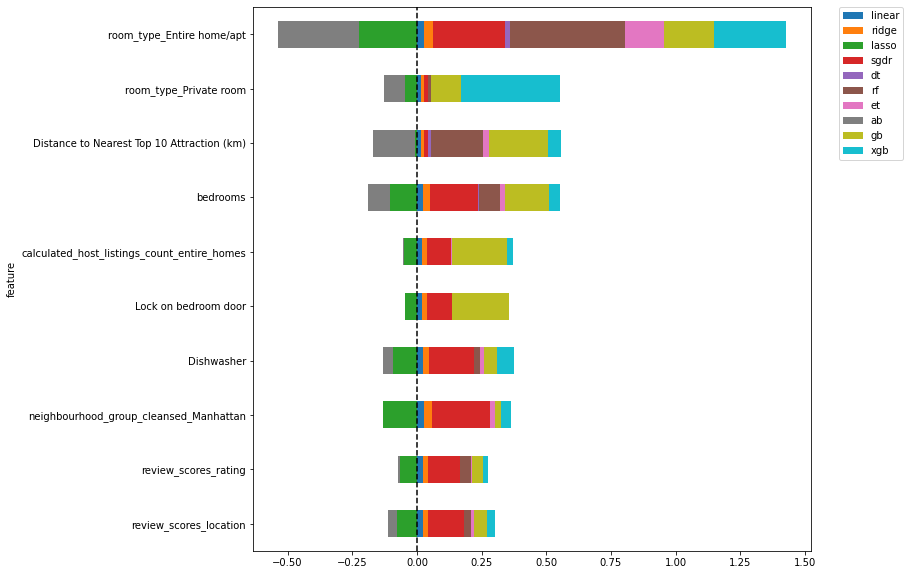

In [47]:
# Plot stacked horizontal bar chart of importance_weighted using matplotlib
importance_weighted['importance_total'] = importance_weighted.sum(axis=1)
importance_weighted.sort_values(by='importance_total', ascending=False, inplace=True)
importance_plot = importance_weighted[:10].sort_values(by='importance_total', ascending=True)
importance_plot.drop(columns=['importance_total'], inplace=True)

importance_plot.plot(kind='barh', stacked=True, figsize=(10,10), color=[c for c in sns.color_palette()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(x=0, color='black', linestyle='--')

**Build a stacking model by using only tree models**

In [48]:
# Select only trees model
regressors_tree = regressors[4:10]
# Create a stacking regressor
clf = StackingRegressor(estimators=regressors_tree, n_jobs=-1, passthrough=False)
# Fit the model
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('dt',
                               Pipeline(steps=[('trans',
                                                ColumnTransformer(transformers=[('txt_kw',
                                                                                 CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                                                                 max_features=200),
                                                                                 'amenities'),
                                                                                ('oe',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['host_is_superhost',
                                                                                  'host_has_profile_pic',
                                   

In [49]:
# Show performance of the stacking model
stacking_importance = show_performance('Stacking', clf, X_test, y_test)
display(stacking_importance)

R2 score for train: 0.90
R2 score for test: 0.70
Mean squared error: 1254.21


,Final Estimator Coefs
xgb,0.444566
rf,0.420323
gb,0.292776
et,0.167018
dt,0.018666
ab,-0.328515


In [50]:
# Remove columns that are not in clf
importance_scaled_sub = importance_scaled.drop(columns=[regressor[0] for regressor in regressors[:4]])
importance_scaled_sub.drop(columns=['total'], inplace=True)
importance_scaled_sub

,dt,rf,et,ab,gb,xgb
feature,,,,,,
room_type_Entire home/apt,1.000000,1.000000,1.000000,1.000000,0.845331,0.716104
bedrooms,0.179625,0.182457,0.147681,0.265144,0.728902,0.114299
Distance to Nearest Top 10 Attraction (km),0.435207,0.452207,0.162476,0.517986,1.000000,0.123458
neighbourhood_group_cleansed_Manhattan,0.000000,0.001435,0.125043,0.000000,0.100817,0.101653
host_has_profile_pic_t,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
room_type_Shared room,0.000000,0.000709,0.001370,0.000000,0.037270,0.031315
property_type_Shared room in condominium (condo),0.000000,0.000000,0.000032,0.000000,0.000000,0.000000
property_type_Private room in condominium (condo),0.000000,0.000149,0.000074,0.000000,0.001245,0.000000


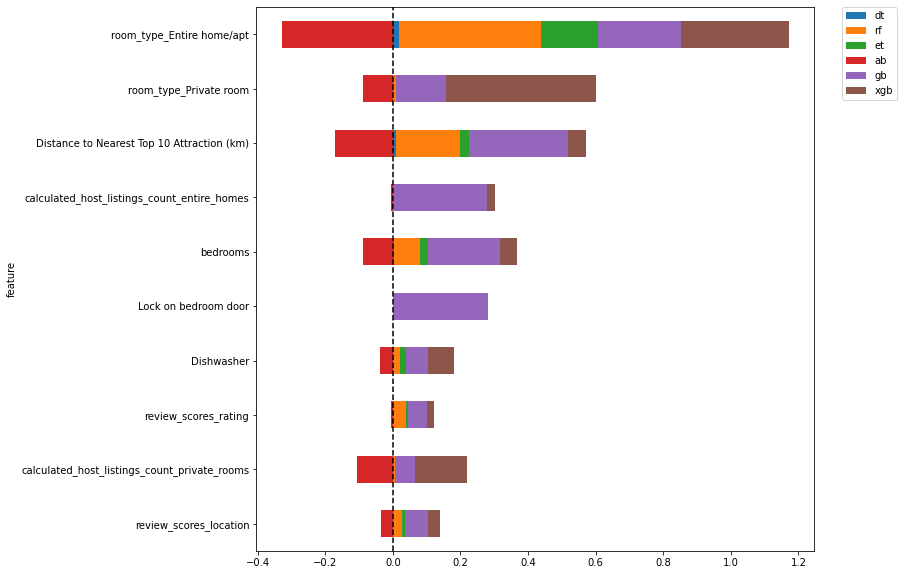

In [51]:
def multiply_stacking(column):
    multiplier = float(stacking_importance.loc[stacking_importance.index == column.name]['Final Estimator Coefs'])
    return column * multiplier

# Multiply importance_scaled by stacking_importance's Final Estimator Coefs by column
importance_weighted = importance_scaled_sub.apply(multiply_stacking, axis=0)

# Plot stacked horizontal bar chart of importance_weighted using matplotlib
importance_weighted['importance_total'] = importance_weighted.sum(axis=1)
importance_weighted.sort_values(by='importance_total', ascending=False, inplace=True)
importance_plot = importance_weighted[:10].sort_values(by='importance_total', ascending=True)
importance_plot.drop(columns=['importance_total'], inplace=True)

importance_plot.plot(kind='barh', stacked=True, figsize=(10,10), color=[c for c in sns.color_palette()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(x=0, color='black', linestyle='--')

### V. FIXING OVERFITTING ISSUE

In [52]:
########## Pipeline for features #############
# Reduce max_feature for features extracted from list_col from 200 to 5
cols_trans = ColumnTransformer([
    ('txt_kw', CountVectorizer(analyzer=no_analyzer, max_features=5), list_col),
    ('oe', OneHotEncoder(handle_unknown = 'ignore'), cat_cols),
    ('number', StandardScaler(), num_cols)], remainder='drop')

In [53]:
pipe = Pipeline([
    ('trans', cols_trans),
    ('model', LinearRegression())
])

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                                  max_features=5),
                                                  'amenities'),
                                                 ('oe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'neighbourhood_group_cleansed',
                                                   'property_type', 'room_type',
                                                   'instant_booka...
                                           

In [55]:
# get important features
txt_kw = list(pipe.steps[0][1].named_transformers_['txt_kw'].get_feature_names_out())
oe = list(pipe.steps[0][1].named_transformers_['oe'].get_feature_names_out())
features = []
features_cat = []
for i in [('Tokenized_amenities', txt_kw), ('Categorical', oe), ('Numeric', num_cols)]:
    features.extend(i[1])
    features_cat.extend([i[0]]*len(i[1]))

In [56]:
# Create the models and append it to regressors
regressors = []
regressors.append(('linear', pipe))
regressors.append(('ridge', RandomizedSearchCV_function(X_train, y_train, Ridge(), {'model__alpha': [10,100,1000], 'model__fit_intercept': [True, False], 'model__random_state': [2022]})))
regressors.append(('lasso', RandomizedSearchCV_function(X_train, y_train, Lasso(max_iter=10000), {'model__alpha': [10,100,1000], 'model__fit_intercept': [True, False], 'model__random_state': [2022]})))
regressors.append(('sgdr', RandomizedSearchCV_function(X_train, y_train, SGDRegressor(), {'model__alpha': [10,100, 1000], 'model__fit_intercept': [True, False], 'model__penalty': ['l1', 'l2'], 'model__random_state': [2022]})))
regressors.append(('dt', RandomizedSearchCV_function(X_train, y_train, DecisionTreeRegressor(), {'model__max_depth': randint(2,3), 'model__min_samples_split': randint(150,200), 'model__min_samples_leaf': randint(2,10), 'model__max_features': [None, 'sqrt', 'log2'], 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'], 'model__random_state': [2022]})))
regressors.append(('rf', RandomizedSearchCV_function(X_train, y_train, RandomForestRegressor(), {'model__criterion': ['squared_error', 'absolute_error'], 'model__max_depth': randint(2,3), 'model__min_samples_split': randint(50,60), 'model__min_samples_leaf': randint(2,10), 'model__max_features': [None, 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('et', RandomizedSearchCV_function(X_train, y_train, ExtraTreesRegressor(), {'model__criterion': ['squared_error', 'absolute_error'], 'model__max_depth': randint(2,3), 'model__min_samples_split': randint(150,200), 'model__min_samples_leaf': randint(2,10), 'model__max_features': [None, 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('ab', RandomizedSearchCV_function(X_train, y_train, AdaBoostRegressor(DecisionTreeRegressor(max_depth=2)), {'model__n_estimators': randint(30,70), 'model__learning_rate': [0.01,0.1,1], 'model__random_state': [2022]})))
regressors.append(('gb', RandomizedSearchCV_function(X_train, y_train, GradientBoostingRegressor(), {'model__subsample': np.arange(0.2, 0.4, 0.1), 'model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'model__learning_rate': [0.01,0.1,1], 'model__criterion': ['friedman_mse', 'squared_error'], 'model__min_samples_split': randint(150,200), 'model__min_samples_leaf': randint(2,10), 'model__max_features': [ 'sqrt', 'log2'], 'model__random_state': [2022]})))
regressors.append(('xgb', RandomizedSearchCV_function(X_train, y_train, xgb.XGBRegressor(), {'model__max_depth': [2],'model__colsample_bytree': np.arange(0.3, 0.5, 0.1),'model__subsample': np.arange(0.3, 0.5, 0.1), 'model__learning_rate': [0.01, 0.1, 0.2], 'model__n_estimators': [30, 40], 'model__random_state': [2022]})))


c:\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score for Ridge: 0.6097589996985204
Best parameters:  {'model__random_state': 2022, 'model__fit_intercept': True, 'model__alpha': 10}


c:\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score for Lasso: 0.4280238496957245
Best parameters:  {'model__random_state': 2022, 'model__fit_intercept': False, 'model__alpha': 10}


c:\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score for SGDRegressor: 0.4322065668620036
Best parameters:  {'model__random_state': 2022, 'model__penalty': 'l1', 'model__fit_intercept': False, 'model__alpha': 10}
Best score for DecisionTreeRegressor: 0.4710924110353753
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__max_features': None, 'model__min_samples_leaf': 3, 'model__min_samples_split': 181, 'model__random_state': 2022}
Best score for RandomForestRegressor: 0.48962255088865375
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 56, 'model__random_state': 2022}
Best score for ExtraTreesRegressor: 0.45768637068611506
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 160, 'model__random_state': 2022}
Best score for AdaBoostRegressor: 0.5045662054074793
Best p

In [57]:
print('Model name:', 'linear')
importance = show_performance(str(regressors[0][0]), regressors[0][1], X_test, y_test)
print('='*50)
for regressor in regressors[1:]:
    print('Model name:', regressor[0])
    importance_sub = show_performance(str(regressor[0]), regressor[1], X_test, y_test)
    print('='*50)
    importance = pd.merge(importance, importance_sub[[c for c in importance_sub.columns if c != 'type']], how='left', on='feature')
importance.set_index(keys='feature', inplace=True)
importance.head(5)

Model name: linear
R2 score for train: 0.64
R2 score for test: -57211033870481890476032.00
Mean squared error: 242665016167269717715714048.00
Model name: ridge
R2 score for train: 0.63
R2 score for test: 0.60
Mean squared error: 1707.14
Model name: lasso
R2 score for train: 0.43
R2 score for test: 0.41
Mean squared error: 2482.67
Model name: sgdr
R2 score for train: 0.43
R2 score for test: 0.43
Mean squared error: 2411.32
Model name: dt
R2 score for train: 0.48
R2 score for test: 0.48
Mean squared error: 2223.78
Model name: rf
R2 score for train: 0.50
R2 score for test: 0.49
Mean squared error: 2156.17
Model name: et
R2 score for train: 0.47
R2 score for test: 0.46
Mean squared error: 2308.01
Model name: ab
R2 score for train: 0.52
R2 score for test: 0.50
Mean squared error: 2101.95
Model name: gb
R2 score for train: 0.67
R2 score for test: 0.65
Mean squared error: 1479.25
Model name: xgb
R2 score for train: 0.67
R2 score for test: 0.63
Mean squared error: 1561.67


,type,importance_linear,importance_ridge,importance_lasso,importance_sgdr,importance_dt,importance_rf,importance_et,importance_ab,importance_gb,importance_xgb
feature,,,,,,,,,,,
room_type_Hotel room,Categorical,9.026831e+14,16.981702,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010694
room_type_Private room,Categorical,9.026831e+14,-18.903943,-0.00000,0.000000,0.000000,0.015068,0.000000,0.089311,0.162380,0.416996
room_type_Shared room,Categorical,6.656794e+14,-22.952082,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010790,0.015835
room_type_Entire home/apt,Categorical,5.461721e+14,24.874323,49.96942,50.101627,0.757009,0.736312,0.839503,0.368237,0.134231,0.059438
property_type_Entire cottage,Categorical,3.806193e+14,14.202396,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
learners = []
for regress in regressors:
    if regress[0] in ['rigde','sgdr','rf','lasso', 'dt','ab','et','gb']:
        learners.append(regress)
# Create a stacking regressor
clf = StackingRegressor(estimators=learners, n_jobs=-1, passthrough=False)
# Fit the model
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('lasso',
                               Pipeline(steps=[('trans',
                                                ColumnTransformer(transformers=[('txt_kw',
                                                                                 CountVectorizer(analyzer=<function no_analyzer at 0x000001D4F38DB160>,
                                                                                                 max_features=5),
                                                                                 'amenities'),
                                                                                ('oe',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['host_is_superhost',
                                                                                  'host_has_profile_pic',
                                  

In [59]:
# Show performance of the stacking model
stacking_importance = show_performance('Stacking', clf, X_test, y_test)
display(stacking_importance)

R2 score for train: 0.68
R2 score for test: 0.67
Mean squared error: 1413.52


,Final Estimator Coefs
gb,1.081592
lasso,0.246234
ab,0.147586
rf,0.139155
sgdr,0.005214
dt,-0.041148
et,-0.460390


In [64]:
importance

,type,importance_linear,importance_ridge,importance_lasso,importance_sgdr,importance_dt,importance_rf,importance_et,importance_ab,importance_gb,importance_xgb
feature,,,,,,,,,,,
room_type_Hotel room,Categorical,9.026831e+14,16.981702,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010694
room_type_Private room,Categorical,9.026831e+14,-18.903943,-0.00000,0.000000,0.000000,0.015068,0.000000,0.089311,0.162380,0.416996
room_type_Shared room,Categorical,6.656794e+14,-22.952082,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010790,0.015835
room_type_Entire home/apt,Categorical,5.461721e+14,24.874323,49.96942,50.101627,0.757009,0.736312,0.839503,0.368237,0.134231,0.059438
property_type_Entire cottage,Categorical,3.806193e+14,14.202396,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
neighbourhood_group_cleansed_Bronx,Categorical,-7.625599e+14,-4.749812,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003042,0.000000
neighbourhood_group_cleansed_Queens,Categorical,-7.625599e+14,-1.534526,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013246,0.007977
neighbourhood_group_cleansed_Staten Island,Categorical,-7.625599e+14,-23.104412,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
importance = importance[['importance_'+learner[0] for learner in learners]]
importance_scaled = importance
importance_scaled = pd.DataFrame(MinMaxScaler().fit_transform(importance_scaled), columns=importance_scaled.columns, index=importance_scaled.index)
importance_scaled['importance_total'] = importance_scaled.sum(axis=1)
importance_scaled.sort_values(by='importance_total', ascending=False, inplace=True)
importance_scaled.head(5)


,importance_lasso,importance_sgdr,importance_dt,importance_rf,importance_et,importance_ab,importance_gb,importance_total
feature,,,,,,,,
room_type_Entire home/apt,0.708672,1.000000,1.000000,1.000000,1.000000,1.000000,0.826648,6.535321
Distance to Nearest Top 10 Attraction (km),0.000000,0.000000,0.320987,0.337656,0.044520,0.507210,0.715616,1.925988
host_has_profile_pic_t,1.000000,0.712201,0.000000,0.000000,0.000000,0.000000,0.000000,1.712201
bedrooms,0.195602,0.281212,0.000000,0.000000,0.052403,0.322326,0.720406,1.571948
room_type_Private room,0.078255,0.123978,0.000000,0.020464,0.000000,0.242536,1.000000,1.465233


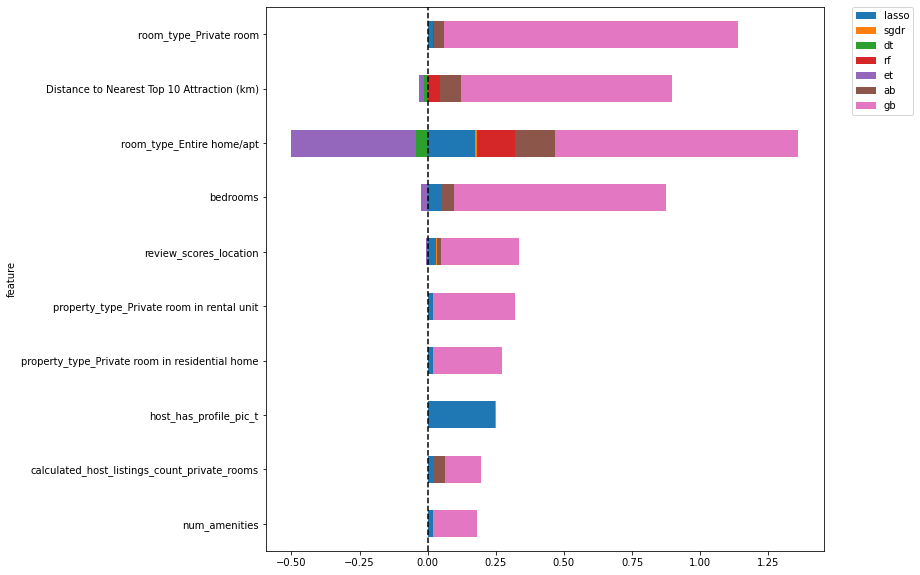

In [67]:
def multiply_stacking(column):
    multiplier = float(stacking_importance.loc[stacking_importance.index == column.name]['Final Estimator Coefs'])
    return column * multiplier

# Remove 'importance_' from names of 'importance_scaled's columns. This is for visualization. 
importance_scaled.columns = [c.replace('importance_', '') for c in importance_scaled.columns]
importance_scaled_sub = importance_scaled.drop('total', axis=1)

# Multiply importance_scaled by stacking_importance's Final Estimator Coefs by column
importance_weighted = importance_scaled_sub.apply(multiply_stacking, axis=0)

# Plot stacked horizontal bar chart of importance_weighted using matplotlib
importance_weighted['importance_total'] = importance_weighted.sum(axis=1)
importance_weighted.sort_values(by='importance_total', ascending=False, inplace=True)
importance_plot = importance_weighted[:10].sort_values(by='importance_total', ascending=True)
importance_plot.drop(columns=['importance_total'], inplace=True)

importance_plot.plot(kind='barh', stacked=True, figsize=(10,10), color=[c for c in sns.color_palette()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(x=0, color='black', linestyle='--')